In [ ]:
!pip install langgraph langchain-core langchain google-generativeai tavily-python rich typing_extensions pydantic

In [ ]:
!pip install -U langchain-google-genai

In [3]:
# Formatting & Display
from rich.console import Console
from rich.panel import Panel
from rich.text import Text
from IPython.display import Image, display

# Core Python
import os
import json
import operator
from pathlib import Path
from datetime import datetime

# Typing & Validation
from typing_extensions import TypedDict, Annotated, List, Literal, Sequence
from pydantic import BaseModel, Field

# LangChain / LangGraph
from langchain.chat_models import init_chat_model
from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_core.messages import (
    BaseMessage, SystemMessage, HumanMessage, ToolMessage, filter_messages
)
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool, InjectedToolArg
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# Tavily API
from tavily import TavilyClient

# Initialize the Console object
console = Console()

In [ ]:
import os
import getpass

# Secure API key input
if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key: ")

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google API key: ")

In [5]:
rate_limiter = InMemoryRateLimiter(
    requests_per_second=1/30,   # 1 request every 30 seconds
    check_every_n_seconds=1,    # check every second
    max_bucket_size=1
)


model=init_chat_model("gemini-2.5-pro",model_provider="google_genai",temperature=0,rate_limiter=rate_limiter)

In [6]:
research_agent_prompt =  """You are a research assistant conducting research on the user's input topic. For context, today's date is {date}.

<Task>
Your job is to use tools to gather information about the user's input topic.
You can use any of the tools provided to you to find resources that can help answer the research question. You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.
</Task>

<Available Tools>
You have access to two main tools:
1. **tavily_search**: For conducting web searches to gather information
2. **think_tool**: For reflection and strategic planning during research

**CRITICAL: Use think_tool after each search to reflect on results and plan next steps**
</Available Tools>

<Instructions>
Think like a human researcher with limited time. Follow these steps:

1. **Read the question carefully** - What specific information does the user need?
2. **Start with broader searches** - Use broad, comprehensive queries first
3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?
4. **Execute narrower searches as you gather information** - Fill in the gaps
5. **Stop when you can answer confidently** - Don't keep searching for perfection
</Instructions>

<Hard Limits>
**Tool Call Budgets** (Prevent excessive searching):
- **Simple queries**: Use 2-3 search tool calls maximum
- **Complex queries**: Use up to 5 search tool calls maximum
- **Always stop**: After 5 search tool calls if you cannot find the right sources

**Stop Immediately When**:
- You can answer the user's question comprehensively
- You have 3+ relevant examples/sources for the question
- Your last 2 searches returned similar information
</Hard Limits>

<Show Your Thinking>
After each search tool call, use think_tool to analyze the results:
- What key information did I find?
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?
</Show Your Thinking>
"""

In [7]:
def show_prompt(prompt_text: str, title: str = "Prompt", border_style: str = "blue"):
    """
    Display a prompt with rich formatting and XML tag highlighting.

    Args:
        prompt_text: The prompt string to display
        title: Title for the panel (default: "Prompt")
        border_style: Border color style (default: "blue")
    """
    # Create a formatted display of the prompt
    formatted_text = Text(prompt_text)
    formatted_text.highlight_regex(r'<[^>]+>', style="bold blue")  # Highlight XML tags
    formatted_text.highlight_regex(r'##[^#\n]+', style="bold magenta")  # Highlight headers
    formatted_text.highlight_regex(r'###[^#\n]+', style="bold cyan")  # Highlight sub-headers

    # Display in a panel for better presentation
    console.print(Panel(
        formatted_text,
        title=f"[bold green]{title}[/bold green]",
        border_style=border_style,
        padding=(1, 2)
    ))

In [8]:
show_prompt(research_agent_prompt,'Research Agent Instruction')

╭────────────────────────────────────────── Research Agent Instruction ───────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Complex queries**: Use up to 5 search tool calls maximum                                                   │
│  - **Always stop**: After 5 search tool calls if you cannot find the right sources                              │
│                                                       

In [9]:
import operator
from typing_extensions import TypedDict, Annotated, List, Sequence
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

# STATE DEFINITIONS

class ResearcherState(TypedDict):
    """
    State for the research agent containing message history and research metadata.

    This state tracks the researcher's conversation, iteration count for limiting
    tool calls, the research topic being investigated, compressed findings,
    and raw research notes for detailed analysis.
    """
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]
    tool_call_iterations: int
    research_topic: str
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]

class ResearcherOutputState(TypedDict):
    """
    Output state for the research agent containing final research results.

    This represents the final output of the research process with compressed
    research findings and all raw notes from the research process.
    """
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]

In [10]:
class ClarifyWithUser(BaseModel):
    """Schema for user clarification decisions during scoping phase."""
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )

class ResearchQuestion(BaseModel):
    """Schema for research brief generation."""
    research_brief: str = Field(
        description="A research question that will be used to guide the research.",
    )

class Summary(BaseModel):
    """Schema for webpage content summarization."""
    summary: str = Field(description="Concise summary of the webpage content")
    key_excerpts: str = Field(description="Important quotes and excerpts from the content")

In [11]:
summarize_webpage_prompt = """You are tasked with summarizing the raw content of a webpage retrieved from a web search. Your goal is to create a summary that preserves the most important information from the original web page. This summary will be used by a downstream research agent, so it's crucial to maintain the key details without losing essential information.

Here is the raw content of the webpage:

<webpage_content>
{webpage_content}
</webpage_content>

Please follow these guidelines to create your summary:

1. Identify and preserve the main topic or purpose of the webpage.
2. Retain key facts, statistics, and data points that are central to the content's message.
3. Keep important quotes from credible sources or experts.
4. Maintain the chronological order of events if the content is time-sensitive or historical.
5. Preserve any lists or step-by-step instructions if present.
6. Include relevant dates, names, and locations that are crucial to understanding the content.
7. Summarize lengthy explanations while keeping the core message intact.

When handling different types of content:

- For news articles: Focus on the who, what, when, where, why, and how.
- For scientific content: Preserve methodology, results, and conclusions.
- For opinion pieces: Maintain the main arguments and supporting points.
- For product pages: Keep key features, specifications, and unique selling points.

Your summary should be significantly shorter than the original content but comprehensive enough to stand alone as a source of information. Aim for about 25-30 percent of the original length, unless the content is already concise.

Present your summary in the following format:

```
{{
   "summary": "Your summary here, structured with appropriate paragraphs or bullet points as needed",
   "key_excerpts": "First important quote or excerpt, Second important quote or excerpt, Third important quote or excerpt, ...Add more excerpts as needed, up to a maximum of 5"
}}
```

Here are two examples of good summaries:

Example 1 (for a news article):
```json
{{
   "summary": "On July 15, 2023, NASA successfully launched the Artemis II mission from Kennedy Space Center. This marks the first crewed mission to the Moon since Apollo 17 in 1972. The four-person crew, led by Commander Jane Smith, will orbit the Moon for 10 days before returning to Earth. This mission is a crucial step in NASA's plans to establish a permanent human presence on the Moon by 2030.",
   "key_excerpts": "Artemis II represents a new era in space exploration, said NASA Administrator John Doe. The mission will test critical systems for future long-duration stays on the Moon, explained Lead Engineer Sarah Johnson. We're not just going back to the Moon, we're going forward to the Moon, Commander Jane Smith stated during the pre-launch press conference."
}}
```

Example 2 (for a scientific article):
```json
{{
   "summary": "A new study published in Nature Climate Change reveals that global sea levels are rising faster than previously thought. Researchers analyzed satellite data from 1993 to 2022 and found that the rate of sea-level rise has accelerated by 0.08 mm/year² over the past three decades. This acceleration is primarily attributed to melting ice sheets in Greenland and Antarctica. The study projects that if current trends continue, global sea levels could rise by up to 2 meters by 2100, posing significant risks to coastal communities worldwide.",
   "key_excerpts": "Our findings indicate a clear acceleration in sea-level rise, which has significant implications for coastal planning and adaptation strategies, lead author Dr. Emily Brown stated. The rate of ice sheet melt in Greenland and Antarctica has tripled since the 1990s, the study reports. Without immediate and substantial reductions in greenhouse gas emissions, we are looking at potentially catastrophic sea-level rise by the end of this century, warned co-author Professor Michael Green."
}}
```

Remember, your goal is to create a summary that can be easily understood and utilized by a downstream research agent while preserving the most critical information from the original webpage.

Today's date is {date}.
"""


In [12]:
def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %#d, %Y")

def get_current_dir() -> Path:
    """Get the current directory of the module.

    This function is compatible with Jupyter notebooks and regular Python scripts.

    Returns:
        Path object representing the current directory
    """
    try:
        return Path(__file__).resolve().parent
    except NameError:  # __file__ is not defined
        return Path.cwd()

In [13]:
# CONFIGURATION

summarization_model = init_chat_model("gemini-2.5-pro",model_provider="google_genai",temperature=0,rate_limiter=rate_limiter)
tavily_client = TavilyClient()

In [14]:
# SEARCH FUNCTIONS

def tavily_search_multiple(
    search_queries: List[str],
    max_results: int = 3,
    topic: Literal["general", "news", "finance"] = "general",
    include_raw_content: bool = True,
) -> List[dict]:
    """Perform search using Tavily API for multiple queries.

    Args:
        search_queries: List of search queries to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content

    Returns:
        List of search result dictionaries
    """

    # Execute searches sequentially. Note: yon can use AsyncTavilyClient to parallelize this step.
    search_docs = []
    for query in search_queries:
        result = tavily_client.search(
            query,
            max_results=max_results,
            include_raw_content=include_raw_content,
            topic=topic
        )
        search_docs.append(result)

    return search_docs

def summarize_webpage_content(webpage_content: str) -> str:
    """Summarize webpage content using the configured summarization model.

    Args:
        webpage_content: Raw webpage content to summarize

    Returns:
        Formatted summary with key excerpts
    """
    try:
        # Set up structured output model for summarization
        structured_model = summarization_model.with_structured_output(Summary)

        # Generate summary
        summary = structured_model.invoke([
            HumanMessage(content=summarize_webpage_prompt.format(
                webpage_content=webpage_content,
                date=get_today_str()
            ))
        ])

        # Format summary with clear structure
        formatted_summary = (
            f"<summary>\n{summary.summary}\n</summary>\n\n"
            f"<key_excerpts>\n{summary.key_excerpts}\n</key_excerpts>"
        )

        return formatted_summary

    except Exception as e:
        print(f"Failed to summarize webpage: {str(e)}")
        return webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content

def deduplicate_search_results(search_results: List[dict]) -> dict:
    """Deduplicate search results by URL to avoid processing duplicate content.

    Args:
        search_results: List of search result dictionaries

    Returns:
        Dictionary mapping URLs to unique results
    """
    unique_results = {}

    for response in search_results:
        for result in response['results']:
            url = result['url']
            if url not in unique_results:
                unique_results[url] = result

    return unique_results

def process_search_results(unique_results: dict) -> dict:
    """Process search results by summarizing content where available.

    Args:
        unique_results: Dictionary of unique search results

    Returns:
        Dictionary of processed results with summaries
    """
    summarized_results = {}

    for url, result in unique_results.items():
        # Use existing content if no raw content for summarization
        if not result.get("raw_content"):
            content = result['content']
        else:
            # Summarize raw content for better processing
            content = summarize_webpage_content(result['raw_content'])

        summarized_results[url] = {
            'title': result['title'],
            'content': content
        }

    return summarized_results

def format_search_output(summarized_results: dict) -> str:
    """Format search results into a well-structured string output.

    Args:
        summarized_results: Dictionary of processed search results

    Returns:
        Formatted string of search results with clear source separation
    """
    if not summarized_results:
        return "No valid search results found. Please try different search queries or use a different search API."

    formatted_output = "Search results: \n\n"

    for i, (url, result) in enumerate(summarized_results.items(), 1):
        formatted_output += f"\n\n--- SOURCE {i}: {result['title']} ---\n"
        formatted_output += f"URL: {url}\n\n"
        formatted_output += f"SUMMARY:\n{result['content']}\n\n"
        formatted_output += "-" * 80 + "\n"

    return formatted_output

In [15]:
# RESEARCH TOOLS

@tool(parse_docstring=True)
def tavily_search(
    query: str,
    max_results: Annotated[int, InjectedToolArg] = 3,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> str:
    """Fetch results from Tavily search API with content summarization.

    Args:
        query: A single search query to execute
        max_results: Maximum number of results to return
        topic: Topic to filter results by ('general', 'news', 'finance')
    """
    # Execute search for single query
    search_results = tavily_search_multiple(
        [query],  # Convert single query to list for the internal function
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    )

    # Deduplicate results by URL to avoid processing duplicate content
    unique_results = deduplicate_search_results(search_results)

    # Process results with summarization
    summarized_results = process_search_results(unique_results)

    # Format output for consumption
    return format_search_output(summarized_results)


@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.

    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.

    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?

    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?

    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps
    """
    return f"Reflection recorded: {reflection}"


In [16]:
from pydantic import BaseModel, Field
from typing_extensions import Literal

from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, filter_messages
from langchain.chat_models import init_chat_model

In [17]:
compress_research_system_prompt = """You are a research assistant that has conducted research on a topic by calling several tools and web searches. Your job is now to clean up the findings, but preserve all of the relevant statements and information that the researcher has gathered. For context, today's date is {date}.

<Task>
You need to clean up information gathered from tool calls and web searches in the existing messages.
All relevant information should be repeated and rewritten verbatim, but in a cleaner format.
The purpose of this step is just to remove any obviously irrelevant or duplicate information.
For example, if three sources all say "X", you could say "These three sources all stated X".
Only these fully comprehensive cleaned findings are going to be returned to the user, so it's crucial that you don't lose any information from the raw messages.
</Task>

<Tool Call Filtering>
**IMPORTANT**: When processing the research messages, focus only on substantive research content:
- **Include**: All tavily_search results and findings from web searches
- **Exclude**: think_tool calls and responses - these are internal agent reflections for decision-making and should not be included in the final research report
- **Focus on**: Actual information gathered from external sources, not the agent's internal reasoning process

The think_tool calls contain strategic reflections and decision-making notes that are internal to the research process but do not contain factual information that should be preserved in the final report.
</Tool Call Filtering>

<Guidelines>
1. Your output findings should be fully comprehensive and include ALL of the information and sources that the researcher has gathered from tool calls and web searches. It is expected that you repeat key information verbatim.
2. This report can be as long as necessary to return ALL of the information that the researcher has gathered.
3. In your report, you should return inline citations for each source that the researcher found.
4. You should include a "Sources" section at the end of the report that lists all of the sources the researcher found with corresponding citations, cited against statements in the report.
5. Make sure to include ALL of the sources that the researcher gathered in the report, and how they were used to answer the question!
6. It's really important not to lose any sources. A later LLM will be used to merge this report with others, so having all of the sources is critical.
</Guidelines>

<Output Format>
The report should be structured like this:
**List of Queries and Tool Calls Made**
**Fully Comprehensive Findings**
**List of All Relevant Sources (with citations in the report)**
</Output Format>

<Citation Rules>
- Assign each unique URL a single citation number in your text
- End with ### Sources that lists each source with corresponding numbers
- IMPORTANT: Number sources sequentially without gaps (1,2,3,4...) in the final list regardless of which sources you choose
- Example format:
  [1] Source Title: URL
  [2] Source Title: URL
</Citation Rules>

Critical Reminder: It is extremely important that any information that is even remotely relevant to the user's research topic is preserved verbatim (e.g. don't rewrite it, don't summarize it, don't paraphrase it).
"""


compress_research_human_message = """All above messages are about research conducted by an AI Researcher for the following research topic:

RESEARCH TOPIC: {research_topic}

Your task is to clean up these research findings while preserving ALL information that is relevant to answering this specific research question.

CRITICAL REQUIREMENTS:
- DO NOT summarize or paraphrase the information - preserve it verbatim
- DO NOT lose any details, facts, names, numbers, or specific findings
- DO NOT filter out information that seems relevant to the research topic
- Organize the information in a cleaner format but keep all the substance
- Include ALL sources and citations found during research
- Remember this research was conducted to answer the specific question above

The cleaned findings will be used for final report generation, so comprehensiveness is critical."""


In [18]:
# Set up tools and model binding
tools = [tavily_search, think_tool]
tools_by_name = {tool.name: tool for tool in tools}

# Initialize models
# model = init_chat_model(model="anthropic:claude-sonnet-4-20250514") already we have one
model=init_chat_model("gemini-2.5-pro",model_provider="google_genai",temperature=0,rate_limiter=rate_limiter)
model_with_tools = model.bind_tools(tools)
summarization_model = init_chat_model("gemini-2.5-pro",model_provider="google_genai",temperature=0,rate_limiter=rate_limiter)
compress_model = init_chat_model("gemini-2.5-pro",model_provider="google_genai",temperature=0,rate_limiter=rate_limiter)

In [24]:
# ROUTING LOGIC

def should_continue(state: ResearcherState) -> Literal["tool_node", "compress_research"]:
    """Determine whether to continue research or provide final answer.

    Determines whether the agent should continue the research loop or provide
    a final answer based on whether the LLM made tool calls.

    Returns:
        "tool_node": Continue to tool execution
        "compress_research": Stop and compress research
    """
    messages = state["researcher_messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, continue to tool execution
    if last_message.tool_calls:
        return "tool_node"
    # Otherwise, we have a final answer
    return "compress_research"

In [25]:
# GRAPH CONSTRUCTION

# Build the agent workflow
agent_builder = StateGraph(ResearcherState, output_schema=ResearcherOutputState)

# Add nodes to the graph
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)
agent_builder.add_node("compress_research", compress_research)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_node": "tool_node", # Continue research loop
        "compress_research": "compress_research", # Provide final answer
    },
)
agent_builder.add_edge("tool_node", "llm_call") # Loop back for more research
agent_builder.add_edge("compress_research", END)

# Compile the agent
researcher_agent = agent_builder.compile()

In [26]:
# NODE FUNCTIONS

def llm_call(state: ResearcherState) -> dict:
    """Invoke the LLM to make decisions and generate tool calls."""
    console.print(Panel("Calling the LLM to make decisions...", title="[bold yellow]LLM Call[/bold yellow]", border_style="yellow"))
    messages = state["researcher_messages"]

    # Use the model with tools to generate a response
    response = model_with_tools.invoke(
        messages,
        config=RunnableConfig(
            recursion_limit=50,
            # Set to none because we are managing interruption
            run_name="Researcher Agent LLM Call",
        ),
    )

    # Append the LLM's response to the message history
    return {"researcher_messages": [response]}

def tool_node(state: ResearcherState) -> dict:
    """Execute tool calls and process their outputs."""
    console.print(Panel("Executing tool calls...", title="[bold blue]Tool Execution[/bold blue]", border_style="blue"))
    messages = state["researcher_messages"][-1] # Get the latest LLM message

    tool_outputs = []
    for tool_call in messages.tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]

        if tool_name in tools_by_name:
            console.print(Panel(f"Executing tool: {tool_name} with args: {tool_args}", title=f"[bold green]Running {tool_name}[/bold green]", border_style="green"))
            try:
                # Execute the tool
                output = tools_by_name[tool_name].invoke(tool_args)
                tool_outputs.append(ToolMessage(content=str(output), tool_call_id=tool_call['id']))
                console.print(Panel(f"Tool {tool_name} executed successfully.", title=f"[bold green]{tool_name} Success[/bold green]", border_style="green"))
            except Exception as e:
                print(f"Error executing tool {tool_name}: {e}")
                tool_outputs.append(ToolMessage(content=f"Error executing tool {tool_name}: {e}", tool_call_id=tool_call['id']))
        else:
            tool_outputs.append(ToolMessage(content=f"Tool {tool_name} not found.", tool_call_id=tool_call['id']))
            console.print(Panel(f"Tool {tool_name} not found.", title=f"[bold red]{tool_name} Not Found[/bold red]", border_style="red"))

    # Append tool outputs to message history
    return {"researcher_messages": tool_outputs}


def compress_research(state: ResearcherState) -> ResearcherOutputState:
    """Compress research findings and return raw notes."""
    console.print(Panel("Compressing research findings...", title="[bold magenta]Compressing Research[/bold magenta]", border_style="magenta"))

    # Filter out the tool calls and responses to focus on substantive content
    research_messages = filter_messages(state["researcher_messages"], include_types=[SystemMessage, HumanMessage, ToolMessage])


    # Use the compress model to process the research messages
    compressed_output = compress_model.invoke([
        SystemMessage(content=compress_research_system_prompt.format(date=get_today_str())),
        HumanMessage(content=compress_research_human_message.format(research_topic=state["research_topic"])),
         # Add the filtered research messages for compression
         *research_messages # Unpack the filtered messages

    ])

    # Extract compressed research and raw notes
    compressed_research = compressed_output.content
    raw_notes = [str(msg) for msg in state["researcher_messages"]]  # Save all messages as raw notes

    console.print(Panel("Research compression complete.", title="[bold magenta]Compression Complete[/bold magenta]", border_style="magenta"))

    # Return the compressed research and raw notes in the output state format
    return ResearcherOutputState(
        compressed_research=compressed_research,
        raw_notes=raw_notes,
        researcher_messages=state["researcher_messages"] # Keep the full message history in the state
    )

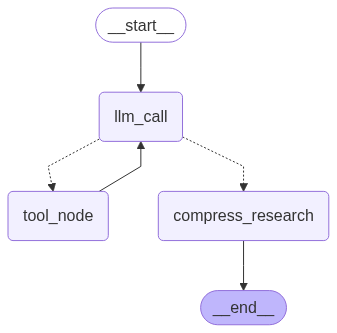

In [27]:
from IPython.display import Image, display
display(Image(researcher_agent.get_graph(xray=True).draw_mermaid_png()))

In [28]:
def format_message_content(message):
    """Convert message content to displayable string"""
    parts = []
    tool_calls_processed = False

    # Handle main content
    if isinstance(message.content, str):
        parts.append(message.content)
    elif isinstance(message.content, list):
        # Handle complex content like tool calls (Anthropic format)
        for item in message.content:
            if item.get('type') == 'text':
                parts.append(item['text'])
            elif item.get('type') == 'tool_use':
                parts.append(f"\n Tool Call: {item['name']}")
                parts.append(f"   Args: {json.dumps(item['input'], indent=2)}")
                parts.append(f"   ID: {item.get('id', 'N/A')}")
                tool_calls_processed = True
    else:
        parts.append(str(message.content))

    # Handle tool calls attached to the message (OpenAI format) - only if not already processed
    if not tool_calls_processed and hasattr(message, 'tool_calls') and message.tool_calls:
        for tool_call in message.tool_calls:
            parts.append(f"\n Tool Call: {tool_call['name']}")
            parts.append(f"   Args: {json.dumps(tool_call['args'], indent=2)}")
            parts.append(f"   ID: {tool_call['id']}")

    return "\n".join(parts)


def format_messages(messages):
    """Format and display a list of messages with Rich formatting"""
    for m in messages:
        msg_type = m.__class__.__name__.replace('Message', '')
        content = format_message_content(m)

        if msg_type == 'Human':
            console.print(Panel(content, title="Human", border_style="blue"))
        elif msg_type == 'Ai':
            console.print(Panel(content, title="Assistant", border_style="green"))
        elif msg_type == 'Tool':
            console.print(Panel(content, title="Tool Output", border_style="yellow"))
        else:
            console.print(Panel(content, title=f" {msg_type}", border_style="white"))

In [30]:
from langchain_core.messages import HumanMessage

# Example brief
research_brief =research_brief = """I want to explore and analyze the effectiveness of public parks in New York City in promoting
physical activity and overall well-being. The research should focus on comparing parks across different boroughs, taking into
account factors such as accessibility, available recreational facilities, maintenance, and visitor usage patterns. Primary data
sources should include official NYC Parks Department reports, publicly available GIS and demographic datasets, and reputable
surveys or studies published by universities or research organizations. The study should produce a summary of which parks are
most effective at encouraging active lifestyles, supported by evidence from quantitative and qualitative sources, and provide
recommendations for improving underperforming parks as of the latest available data in 2025."""


result = researcher_agent.invoke({"researcher_messages": [HumanMessage(content=f"{research_brief}.")], "research_topic": research_brief})
format_messages(result['researcher_messages'])

╭─────────────────────────────────────────────────── LLM Call ────────────────────────────────────────────────────╮
│ Calling the LLM to make decisions...                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Tool Execution ─────────────────────────────────────────────────╮
│ Executing tool calls...                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── Running tavily_search ─────────────────────────────────────────────╮
│ Executing tool: tavily_search with args: {'query': 'NYC Parks Department report on park usage physical activity │
│ and well-being by borough 2023-2024'}                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── tavily_search Success ─────────────────────────────────────────────╮
│ Tool tavily_search executed successfully.                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── LLM Call ────────────────────────────────────────────────────╮
│ Calling the LLM to make decisions...                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Tool Execution ─────────────────────────────────────────────────╮
│ Executing tool calls...                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────── Running think_tool ───────────────────────────────────────────────╮
│ Executing tool: think_tool with args: {'reflection': "The initial search yielded two Preliminary Mayor's        │
│ Management Reports (PMMR) for the NYC Department of Parks and Recreation (DPR) for fiscal years 2024 and 2025.  │
│ These reports provide a good, high-level overview of the department's goals, initiatives (like the Community    │
│ Parks Initiative), and city-wide performance metrics related to park conditions, maintenance, and public        │
│ engagement. I also found a promising study on the impact of park renovation on park use.\n\nHowever, there are  │
│ significant gaps. The current data is aggregated at the city level and does not offer the borough-specific      │
│ breakdown required for the comparative analysis the user wants. I am also missing direct evidence of physical   │
│ activity levels in parks, detailed visitor usage patterns, and qualitative data on user                         │
│ perceptions.\n\nTherefore, my next step will be to find data that is broken down by borough. This is the most   │
│ critical missing piece to fulfill the user's request. I will search for official reports or datasets that       │
│ provide this level of granularity."}                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────── think_tool Success ───────────────────────────────────────────────╮
│ Tool think_tool executed successfully.                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── Running tavily_search ─────────────────────────────────────────────╮
│ Executing tool: tavily_search with args: {'query': 'NYC Parks Department borough-specific data on park usage    │
│ facilities and conditions'}                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── tavily_search Success ─────────────────────────────────────────────╮
│ Tool tavily_search executed successfully.                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── LLM Call ────────────────────────────────────────────────────╮
│ Calling the LLM to make decisions...                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── Compressing Research ──────────────────────────────────────────────╮
│ Compressing research findings...                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── Compression Complete ──────────────────────────────────────────────╮
│ Research compression complete.                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── Human ─────────────────────────────────────────────────────╮
│ I want to explore and analyze the effectiveness of public parks in New York City in promoting physical activity │
│ and overall well-being. The research should focus on comparing parks across different boroughs, taking into     │
│ account factors such as accessibility, available recreational facilities, maintenance, and visitor usage        │
│ patterns. Primary data sources should include official NYC Parks Department reports, publicly available GIS and │
│ demographic datasets, and reputable surveys or studies published by universities or research organizations. The │
│ study should produce a summary of which parks are most effective at encouraging active lifestyles, supported by │
│ evidence from quantitative and qualitative sources, and provide recommendations for improving underperforming   │
│ parks as of the latest available data in 2025..                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────────  AI ──────────────────────────────────────────────────────╮
│ Of course. I will begin by conducting a thorough research and analysis process to evaluate the effectiveness of │
│ New York City's public parks in promoting physical activity and well-being, with a focus on comparing parks     │
│ across different boroughs.                                                                                      │
│                                                                                                                 │
│ My research will proceed in the following stages:                                                               │
│ 1.  I will start by searching for comprehensive, high-level reports from the NYC Parks Department and reputable │
│ third-party organizations that provide a city-wide overview and borough-by-borough comparisons.                 │
│ 2.  Next, I will look for specific datasets related to park accessibility, recreational facility availability,  │
│ and maintenance scores to gather quantitative evidence.                                                         │
│ 3.  I will then search for academic studies and surveys that analyze visitor usage patterns and the direct      │
│ impact of these parks on public health and well-being.                                                          │
│ 4.  Finally, I will synthesize all the gathered information to identify the most effective parks, highlight     │
│ disparities, and provide evidence-based recommendations for improving underperforming parks as of the latest    │
│ available data.                                                                                                 │
│                                                                                                                 │
│ I will now begin with the first step to find foundational reports.                                              │
│                                                                                                                 │
│  Tool Call: tavily_search                                                                                       │
│    Args: {                                                                                                      │
│   "query": "NYC Parks Department report on park usage physical activity and well-being by borough 2023-2024"    │
│ }                                                                                                               │
│    ID: b4b970f0-d36a-4cab-8a6f-8652a4b92564                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Output ──────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: [PDF] Department of Parks and Recreation - NYC.gov ---                                            │
│ URL: https://www.nyc.gov/assets/operations/downloads/pdf/pmmr2024/dpr.pdf                                       │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ The New York City Department of Parks and Recreation (DPR), also known as NYC Parks, is responsible for         │
│ managing the city's 2,000 parks, 1,000 playgrounds, 12,000 acres of natural areas, and over 660,000 street      │
│ trees. The department's core mission is to maintain a world-class park system with a focus on equity, access,   │
│ safety, and nature.                                                                                             │
│                                                                                                                 │
│ A primary focus for NYC Parks is equity. The Community Parks Initiative (CPI) is a key program that             │
│ reconstructs parks in historically underserved neighborhoods. Since its launch in 2014, 65 CPI sites have been  │
│ transformed, with a new $425 million investment set to transform an additional 100 parks. In June 2023, the     │
│ agency launched the "Let’s Green NYC" volunteer initiative, which engaged 412,999 participants in Calendar 2023 │
│ to build community and combat loneliness.                                                                       │
│                                                                                                                 │
│ In the first four months of Fiscal Year 2024, NYC Parks demonstrated significant performance improvements       │
│ compared to the same period in Fiscal 2023:                                                                     │
│ - Park conditions improved, with 88% rated acceptable for overall condition and 94% for cleanliness.            │
│ - Tree maintenance surged, with a 150% increase in trees pruned (19,351) and a 110% increase in trees planted   │
│ (5,326).                                                                                                        │
│ - 53 capital projects were completed, with 85% finished on time or early and 89% within budget.                 │
│ - Public engagement increased, with recreation center memberships rising by 19% to 132,961 and attendance       │
│ growing by 56% to 542,312.                                                                                      │
│ - Public safety saw improvements, with a decrease in crimes against persons and property.                       │
│                                                                                                                 │
│ The department's main services and goals are structured around four key areas:                                  │
│ 1.  **Manage facilities:** Ensuring parks and playgrounds are clean and in good condition.                      │
│ 2.  **Manage trees:** Maintaining, preserving, and increasing the number of trees.                              │
│ 3.  **Preserve infrastructure:** Building and improvin

╭──────────────────────────────────────────────────────  AI ──────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  Tool Call: think_tool                                                                                          │
│    Args: {                                                                                                      │
│   "reflection": "The initial search yielded two Preliminary Mayor's Management Reports (PMMR) for the NYC       │
│ Department of Parks and Recreation (DPR) for fiscal years 2024 and 2025. These reports provide a good,          │
│ high-level overview of the department's goals, initiatives (like the Community Parks Initiative), and city-wide │
│ performance metrics related to park conditions, maintenance, and public engagement. I also found a promising    │
│ study on the impact of park renovation on park use.\n\nHowever, there are significant gaps. The current data is │
│ aggregated at the city level and does not offer the borough-specific breakdown required for the comparative     │
│ analysis the user wants. I am also missing direct evidence of physical activity levels in parks, detailed       │
│ visitor usage patterns, and qualitative data on user perceptions.\n\nTherefore, my next step will be to find    │
│ data that is broken down by borough. This is the most critical missing piece to fulfill the user's request. I   │
│ will search for official reports or datasets that provide this level of granularity."                           │
│ }                                                                                                               │
│    ID: 332dcec6-deda-46f1-b051-630916141265                                                                     │
│                                                                                                                 │
│  Tool Call: tavily_search                                                                                       │
│    Args: {                                                                                                      │
│   "query": "NYC Parks Department borough-specific data on park usage facilities and conditions"                 │
│ }                                                                                                               │
│    ID: 69442b1b-ceeb-419b-a6ad-3d0dad52ed15                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Output ──────────────────────────────────────────────────╮
│ Reflection recorded: The initial search yielded two Preliminary Mayor's Management Reports (PMMR) for the NYC   │
│ Department of Parks and Recreation (DPR) for fiscal years 2024 and 2025. These reports provide a good,          │
│ high-level overview of the department's goals, initiatives (like the Community Parks Initiative), and city-wide │
│ performance metrics related to park conditions, maintenance, and public engagement. I also found a promising    │
│ study on the impact of park renovation on park use.                                                             │
│                                                                                                                 │
│ However, there are significant gaps. The current data is aggregated at the city level and does not offer the    │
│ borough-specific breakdown required for the comparative analysis the user wants. I am also missing direct       │
│ evidence of physical activity levels in parks, detailed visitor usage patterns, and qualitative data on user    │
│ perceptions.                                                                                                    │
│                                                                                                                 │
│ Therefore, my next step will be to find data that is broken down by borough. This is the most critical missing  │
│ piece to fulfill the user's request. I will search for official reports or datasets that provide this level of  │
│ granularity.                                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Output ──────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: Parks Inspection Program - NYC Parks ---                                                          │
│ URL: https://www.nycgovparks.org/park-features/parks-inspection-program                                         │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ The New York City Department of Parks & Recreation utilizes the Parks Inspection Program (PIP), a performance   │
│ measurement system to evaluate the condition of its parks and playgrounds. Administered by the Operations and   │
│ Management Planning (OMP) division, the program conducts approximately 6,000 random and detailed inspections    │
│ annually. A team of trained inspectors rates each site as "Acceptable" or "Unacceptable" based on the           │
│ assessment of up to sixteen features across three categories: Cleanliness, Landscape, and Structural. These     │
│ ratings serve as a public indicator of park conditions, help the department target problem areas for effective  │
│ resource allocation, and are included in the Mayor's Management Report to measure the overall condition of the  │
│ city's parks.                                                                                                   │
│ </summary>                                                                                                      │
│                                                                                                                 │
│ <key_excerpts>                                                                                                  │
│ The Parks Inspection Program (PIP) is a comprehensive, outcome-based performance measurement system that        │
│ generates frequent, random, and detailed inspections of our parks and playgrounds. The program has been         │
│ designed to reflect conditions encountered by the public when using Parks facilities. A team of trained         │
│ inspectors uses handheld computers and digital cameras to conduct approximately 6,000 inspections per year.     │
│ Site ratings are derived from the assessment of up to sixteen features, grouped into one of three categories:   │
│ Cleanliness Features, Landscape Features, and Structural Features. The Parks Department uses the PIP ratings to │
│ hold itself accountable to the highest standards of cleanliness, safety, and structural conditions.             │
│ </key_excerpts>                                                                                                 │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2: Parks in NYC - Data Team - NYC Council ---                                                        │
│ URL: https://council.nyc.gov/data/parks-in-nyc/       

╭──────────────────────────────────────────────────────  AI ──────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯